In [16]:
import os
import cv2
import yt_dlp
import numpy as np
import random
from collections import deque
from moviepy.editor import VideoFileClip
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import ConvLSTM2D, Conv2D, MaxPooling2D, MaxPooling3D, Dropout, Flatten, Dense, TimeDistributed, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Seed for reproducibility
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# Constants
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64  # Adjust size if necessary
SEQUENCE_LENGTH = 20
DATASET_DIR = 'UCF50\\UCF50'  # You should have this dataset downloaded
CLASSES_LIST = ['WalkingWithDog', 'TaiChi', 'Swing', 'HorseRace']#,'Biking', 'PullUps','PushUps','VolleyballSpiking'

# 1. Download video from YouTube
def download_video(url, output_path):
    ydl_opts = {
        'format': 'best',
        'outtmpl': f'{output_path}/%(title)s.%(ext)s',
    }
    try:
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.download([url])
        info_dict = ydl.extract_info(url, download=False)
        return info_dict.get('title', None)
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# 2. Extract frames from the video
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255.0
        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list

# 3. Create dataset
def create_dataset():
    features = []
    labels = []
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
    features = np.array(features)
    labels = np.array(labels)
    return features, labels

# Load and split the dataset
features, labels = create_dataset()
one_hot_encoded_labels = to_categorical(labels)
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size=0.25, shuffle=True, random_state=seed_constant)

# 4. Build ConvLSTM Model
def create_convlstm_model():
    model = Sequential()
    model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), activation='tanh', return_sequences=True, input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(Dropout(0.2))
    model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='tanh', return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(Dropout(0.2))
    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh', return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

# 5. Build LRCN Model
def create_lrcn_model():
    model = Sequential()
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'), input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(Dropout(0.25))
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(Dropout(0.25))
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(0.25))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(32))
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

# 6. Train both models
def train_models():
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ''' IT IS A STEP FOR TRAINING ConvLSTM Model IT TAKES MORE TIME COMPARED TO LRCN MODEL TRAINING OF ConvLSTM IS NOT ESSENTIAL 
    print("ConvLSTM Model Training")
    # Train ConvLSTM Model
    convlstm_model = create_convlstm_model()
    convlstm_model.fit(x=features_train, y=labels_train, epochs=10, batch_size=4, validation_split=0.2, callbacks=[early_stopping])
    convlstm_model.save('convlstm_model.h5')'''
    print("LRCN MODEL TRAINING")
    # Train LRCN Model
    lrcn_model = create_lrcn_model()
    lrcn_model.fit(x=features_train, y=labels_train, epochs=50, batch_size=4, validation_split=0.2, callbacks=[early_stopping])
    lrcn_model.save('lrcn_model.h5')

# 7. Live Prediction on YouTube Video
def predict_on_video(video_file_path, output_file_path, model, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, CLASS_LIST):
    video_reader = cv2.VideoCapture(video_file_path)
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc(*'MP4V'), video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
    
    frames_queue = deque(maxlen=SEQUENCE_LENGTH)
    predicted_class_name = ''
    
    while video_reader.isOpened():
        success, frame = video_reader.read()
        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255.0
        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:
            predicted_labels_probabilities = model.predict(np.expand_dims(frames_queue, axis=0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)
            predicted_class_name = CLASS_LIST[predicted_label]

        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        video_writer.write(frame)

    video_reader.release()
    video_writer.release()

if __name__ == "__main__":
    # Step 1: Train models
    train_models()

    # Step 2: Download and predict on YouTube video
    test_videos_directory = 'test_videos'
    os.makedirs(test_videos_directory, exist_ok=True)

    video_url = 'https://youtu.be/4QwSLio0On0?si=0HkG6H5QPNcUkyw-'  # Example YouTube video URL
    video_title = download_video(video_url, test_videos_directory)

    if video_title:
        input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'
        output_video_file_path = f'{test_videos_directory}/{video_title}-Output.mp4'
        
        model = load_model('lrcn_model.h5')  # You can switch to 'convlstm_model.h5' if desired
        predict_on_video(input_video_file_path, output_video_file_path, model, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, CLASSES_LIST)

        # Display the output video
        clip = VideoFileClip(output_video_file_path)
        clip.ipython_display()


Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace
ConvLSTM Model Training
Epoch 1/10
73/73 [==============================] - 208s 3s/step - loss: 1.4006 - accuracy: 0.2568 - val_loss: 1.3375 - val_accuracy: 0.3836
Epoch 2/10
73/73 [==============================] - 200s 3s/step - loss: 1.2776 - accuracy: 0.3973 - val_loss: 2.3151 - val_accuracy: 0.2192
Epoch 3/10
73/73 [==============================] - 203s 3s/step - loss: 1.1731 - accuracy: 0.4897 - val_loss: 1.3430 - val_accuracy: 0.3699
Epoch 4/10
73/73 [==============================] - 201s 3s/step - loss: 0.9931 - accuracy: 0.5959 - val_loss: 1.0296 - val_accuracy: 0.5205
Epoch 5/10
73/73 [==============================] - 200s 3s/step - loss: 0.7889 - accuracy: 0.6952 - val_loss: 0.9152 - val_accuracy: 0.6027
Epoch 6/10
73/73 [==============================] - 198s 3s/step - loss: 0.6705 - accuracy: 0.7432 - val_loss: 0.8855 - val_accur

Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [29]:
if __name__ == "__main__":
    # Step 1: Train models
    train_models()

    # Step 2: Download and predict on YouTube video
    test_videos_directory = 'test_videos'
    os.makedirs(test_videos_directory, exist_ok=True)

    video_url = 'https://youtu.be/4QwSLio0On0?si=0HkG6H5QPNcUkyw-'  # Example YouTube video URL
    video_title = download_video(video_url, test_videos_directory)

    if video_title:
        input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'
        output_video_file_path = f'{test_videos_directory}/{video_title}-Output.mp4'
        
        model = load_model('lrcn_model.h5')  # You can switch to 'convlstm_model.h5' if desired
        predict_on_video(input_video_file_path, output_video_file_path, model, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, CLASSES_LIST)

        # Display the output video
        clip = VideoFileClip(output_video_file_path)
        clip.ipython_display()

ConvLSTM Model Training
Epoch 1/10
73/73 [==============================] - 68s 882ms/step - loss: 1.3367 - accuracy: 0.3356 - val_loss: 1.2593 - val_accuracy: 0.2603
Epoch 2/10
73/73 [==============================] - 65s 890ms/step - loss: 1.1323 - accuracy: 0.5034 - val_loss: 1.0884 - val_accuracy: 0.5616
Epoch 3/10
73/73 [==============================] - 65s 897ms/step - loss: 0.7674 - accuracy: 0.7089 - val_loss: 0.7310 - val_accuracy: 0.6849
Epoch 4/10
73/73 [==============================] - 65s 892ms/step - loss: 0.5949 - accuracy: 0.7432 - val_loss: 0.5624 - val_accuracy: 0.7671
Epoch 5/10
73/73 [==============================] - 63s 865ms/step - loss: 0.4802 - accuracy: 0.8048 - val_loss: 0.7354 - val_accuracy: 0.7123
Epoch 6/10
73/73 [==============================] - 63s 867ms/step - loss: 0.3571 - accuracy: 0.8664 - val_loss: 0.5836 - val_accuracy: 0.7808
Epoch 7/10
73/73 [==============================] - 64s 871ms/step - loss: 0.2655 - accuracy: 0.9007 - val_loss: 0.634

Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [2]:
from IPython.display import Video
Video("__temp__.mp4")


In [30]:
from IPython.display import Video
Video("__temp__.mp4")


In [31]:
model=load_model('lrcn_model.h5')

In [32]:
predections=model.predict(features_test)

4/4 [==============================] - 1s 87ms/step


In [35]:
test_loss, test_accuracy = model.evaluate(features_test, labels_test, verbose=0)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Test Loss: 0.5021, Test Accuracy: 0.8197


4/4 [==============================] - 0s 78ms/step


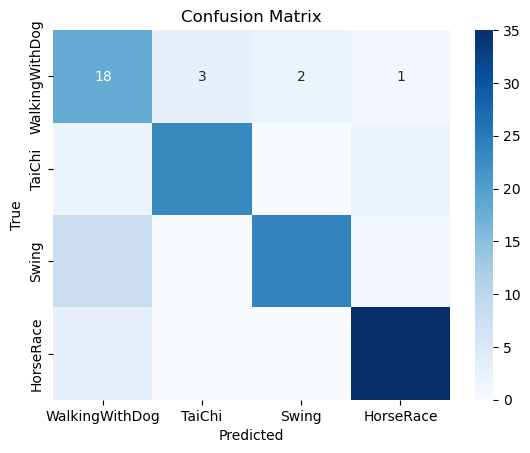

                precision    recall  f1-score   support

WalkingWithDog       0.58      0.75      0.65        24
        TaiChi       0.88      0.85      0.87        27
         Swing       0.92      0.73      0.81        33
     HorseRace       0.90      0.92      0.91        38

      accuracy                           0.82       122
     macro avg       0.82      0.81      0.81       122
  weighted avg       0.84      0.82      0.82       122



In [36]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions for test set
predicted_labels = model.predict(features_test)
predicted_classes = np.argmax(predicted_labels, axis=1)
true_classes = np.argmax(labels_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES_LIST, yticklabels=CLASSES_LIST)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(true_classes, predicted_classes, target_names=CLASSES_LIST))
